# **ResNet50 Compare Basline to Augmentation**
----
What was done in this notebook: I loaded my two ResNet50 models. One trained on original data (baseline) the other the trained with image augmentation (rotation, shifts, zoom, flips). Then evaluated both models on the same test set and lastly plotted ROC curves per class to compare how well each model distinguishes brain tumor types.

Key findings from the ROC curve:
- Glioma: improved
  - Baseline AUC: 0.79
  - Augmented AUC: 0.97
- Meningioma: improved
  - Baseline AUC: 0.70
  - Augmented AUC: 0.98
- No Tumor: slightly improved
  - Baseline AUC: 0.92
  - Augmented AUC: 0.99
- Pituitary Tumor: improved
  - Baseline AUC: 0.86
  - Augmented AUC: 0.98


Overall, the augmented model did better the baseline in all classes, especially in glioma and meningioma

----

In [3]:
# load in imports
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle

In [4]:
# now to load data the models 
test_dir = os.path.join('tumor_data_cleaned', 'Testing')

#  no augmentation
baseline_model = load_model('BrainTumorBaseline_ResNet50.h5')

# augmented 
aug_model = load_model('resnet50_augmented_model.h5')

In [5]:
# load in images
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# get predictions on test set
baseline_preds = baseline_model.predict(test_gen)
aug_preds = aug_model.predict(test_gen)

# get the class labels 
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())
n_classes = len(class_labels)

Found 1311 images belonging to 4 classes.


C:\Users\eliga\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 37s 883ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 34s 809ms/step


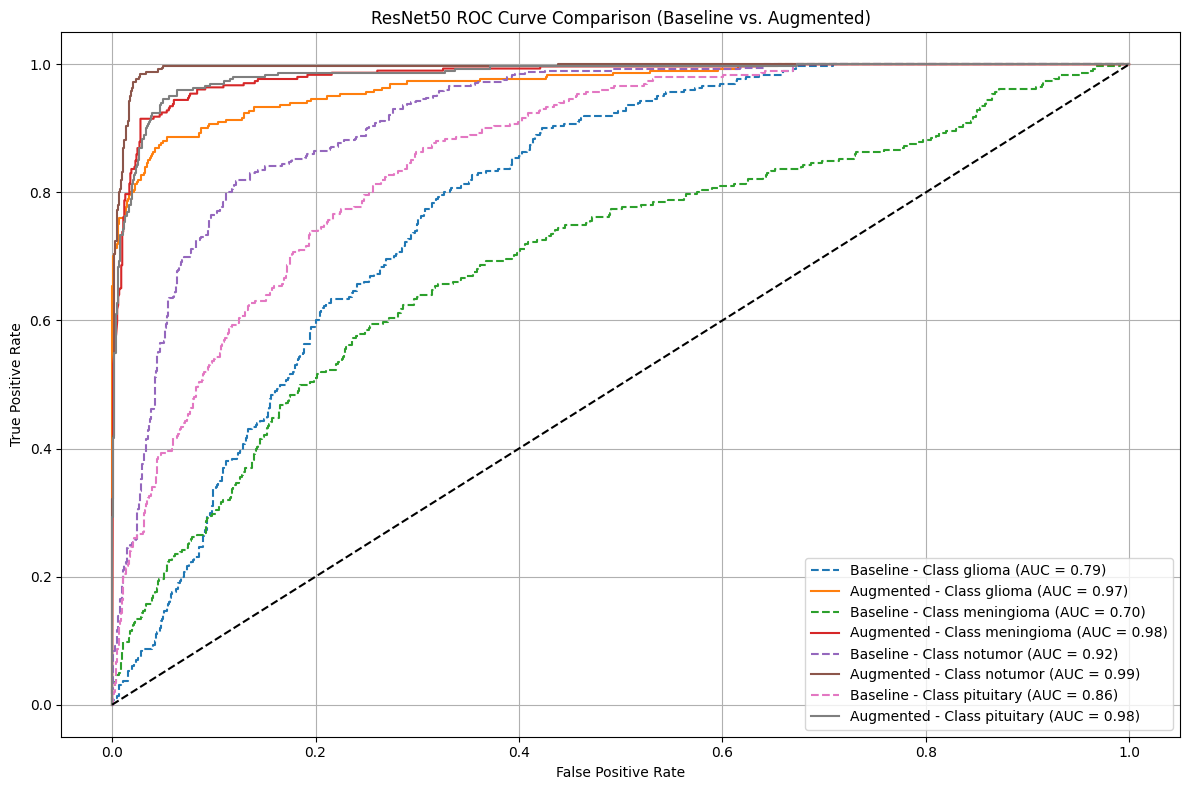

In [9]:
# one-hot encode labels 
y_true_bin = label_binarize(y_true, classes=range(n_classes))

# roc curves for each class
fpr_base, tpr_base, roc_auc_base = {}, {}, {}
fpr_aug, tpr_aug, roc_auc_aug = {}, {}, {}

for i in range(n_classes):
    fpr_base[i], tpr_base[i], _ = roc_curve(y_true_bin[:, i], baseline_preds[:, i])
    roc_auc_base[i] = auc(fpr_base[i], tpr_base[i])

    fpr_aug[i], tpr_aug[i], _ = roc_curve(y_true_bin[:, i], aug_preds[:, i])
    roc_auc_aug[i] = auc(fpr_aug[i], tpr_aug[i])


# plot it
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    plt.plot(fpr_base[i], tpr_base[i], linestyle='--', label=f'Baseline - Class {class_labels[i]} (AUC = {roc_auc_base[i]:.2f})')
    plt.plot(fpr_aug[i], tpr_aug[i], label=f'Augmented - Class {class_labels[i]} (AUC = {roc_auc_aug[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ResNet50 ROC Curve Comparison (Baseline vs. Augmented)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('resnet50_roc_curve.png', dpi=300)
plt.show()